## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import time
import datetime as dt
import urllib.request, json
import os
from pandas_datareader import data
import tweepy
from textblob import TextBlob
import re

Using TensorFlow backend.


## Getting data using Alpha Vantage API

In [2]:
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7TONQ8CM5PXZ4YEO'

    # INFY stock market prices
    ticker = "INFY"

    # JSON file with all the stock market data for INFY from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [3]:
df = pd.read_csv("stock_market_data-INFY.csv")

In [4]:
df = df[['Date', 'Open', 'Close', 'Low', 'High']]

In [5]:
df = df.sort_values('Date')

In [6]:
df.head()

,Date,Open,Close,Low,High
2113,1999-03-11,38.50,46.88,37.38,50.00
1553,1999-03-12,47.00,46.63,43.00,48.75
2874,1999-03-15,46.75,42.38,42.13,46.75
976,1999-03-16,42.75,42.00,42.00,44.25
4249,1999-03-17,42.00,42.25,41.75,44.75


In [7]:
df.tail()

,Date,Open,Close,Low,High
2910,2018-09-28,10.22,10.1700,10.120,10.25
2607,2018-10-01,10.34,10.3700,10.295,10.39
1412,2018-10-02,10.32,10.2700,10.200,10.32
1142,2018-10-03,10.12,10.0400,10.010,10.15
3330,2018-10-04,10.12,9.8511,9.800,9.92


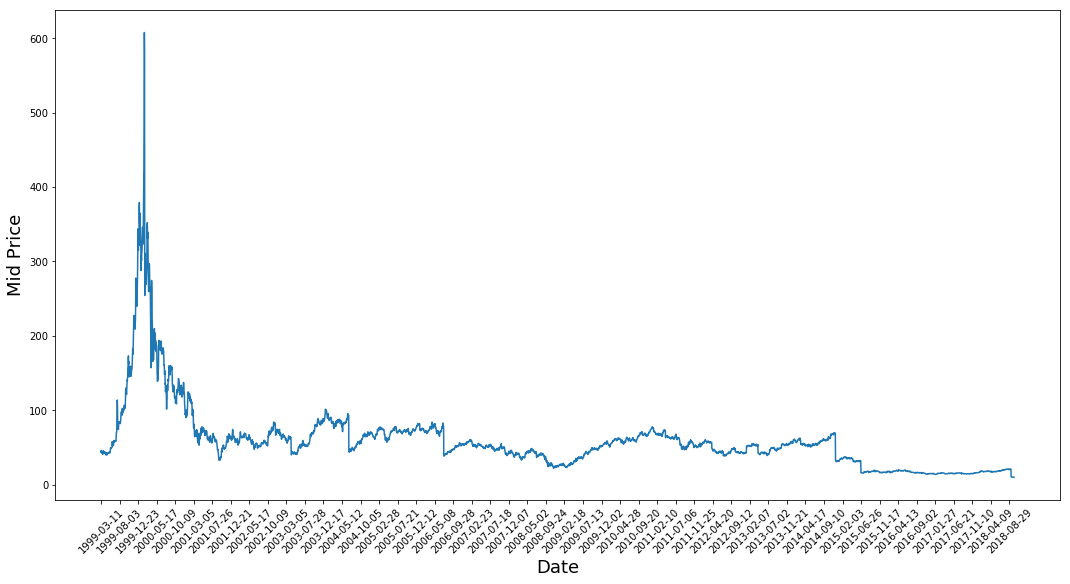

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [9]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
df["Mid Prices"] = (high_prices+low_prices)/2.0

In [10]:
df.head()

,Date,Open,Close,Low,High,Mid Prices
2113,1999-03-11,38.50,46.88,37.38,50.00,43.690
1553,1999-03-12,47.00,46.63,43.00,48.75,45.875
2874,1999-03-15,46.75,42.38,42.13,46.75,44.440
976,1999-03-16,42.75,42.00,42.00,44.25,43.125
4249,1999-03-17,42.00,42.25,41.75,44.75,43.250


## Data Cleaning

In [11]:
df.drop("Date", axis = 1,inplace = True)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
df = scaler.transform(df)

## Building Long-Short Term Memory Cell to implement Recurrent Neural Network

In [15]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=50,
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print ('compilation time : ', time.time() - start)
    return model

## Load data as per model requirements

In [16]:
def load_data(stock, seq_len):
    amount_of_features = 5
    data = stock
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result =  np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [17]:
window = 5
X_train, y_train, X_test, y_test = load_data(df, window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4428, 5, 5)
y_train (4428,)
X_test (492, 5, 5)
y_test (492,)


In [18]:
model = build_model([5,window,1])

compilation time :  0.046828269958496094


## Training Time!

In [19]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=100,
    validation_split=0.1,
    verbose=1)

Train on 3985 samples, validate on 443 samples
Epoch 1/100
3985/3985 [==============================] - 5s 1ms/step - loss: 0.4196 - val_loss: 0.0403
Epoch 2/100
3985/3985 [==============================] - 1s 277us/step - loss: 0.0788 - val_loss: 0.0789
Epoch 3/100
3985/3985 [==============================] - 1s 266us/step - loss: 0.0612 - val_loss: 0.0915
Epoch 4/100
3985/3985 [==============================] - 1s 261us/step - loss: 0.0573 - val_loss: 0.0603
Epoch 5/100
3985/3985 [==============================] - 1s 268us/step - loss: 0.0551 - val_loss: 0.0178
Epoch 6/100
3985/3985 [==============================] - 1s 258us/step - loss: 0.0596 - val_loss: 0.0156
Epoch 7/100
3985/3985 [==============================] - 1s 258us/step - loss: 0.0487 - val_loss: 0.0097
Epoch 8/100
3985/3985 [==============================] - 1s 245us/step - loss: 0.0514 - val_loss: 0.0036
Epoch 9/100
3985/3985 [==============================] - 1s 252us/step - loss: 0.0505 - val_loss: 0.0024
Epoch 10/1

3985/3985 [==============================] - 1s 229us/step - loss: 0.0225 - val_loss: 0.0143
Epoch 78/100
3985/3985 [==============================] - 1s 249us/step - loss: 0.0197 - val_loss: 7.1517e-04
Epoch 79/100
3985/3985 [==============================] - 1s 246us/step - loss: 0.0201 - val_loss: 0.0020
Epoch 80/100
3985/3985 [==============================] - 1s 234us/step - loss: 0.0223 - val_loss: 8.0921e-04
Epoch 81/100
3985/3985 [==============================] - 1s 258us/step - loss: 0.0117 - val_loss: 0.0021
Epoch 82/100
3985/3985 [==============================] - 1s 239us/step - loss: 0.0185 - val_loss: 6.4786e-04
Epoch 83/100
3985/3985 [==============================] - 1s 242us/step - loss: 0.0197 - val_loss: 0.0011
Epoch 84/100
3985/3985 [==============================] - 1s 255us/step - loss: 0.0139 - val_loss: 0.0044
Epoch 85/100
3985/3985 [==============================] - 1s 238us/step - loss: 0.0194 - val_loss: 0.0063
Epoch 86/100
3985/3985 [=======================

In [20]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print(trainScore)

0.00570710248636


## Predictions

In [21]:
p = model.predict(X_test)

## Visualizations

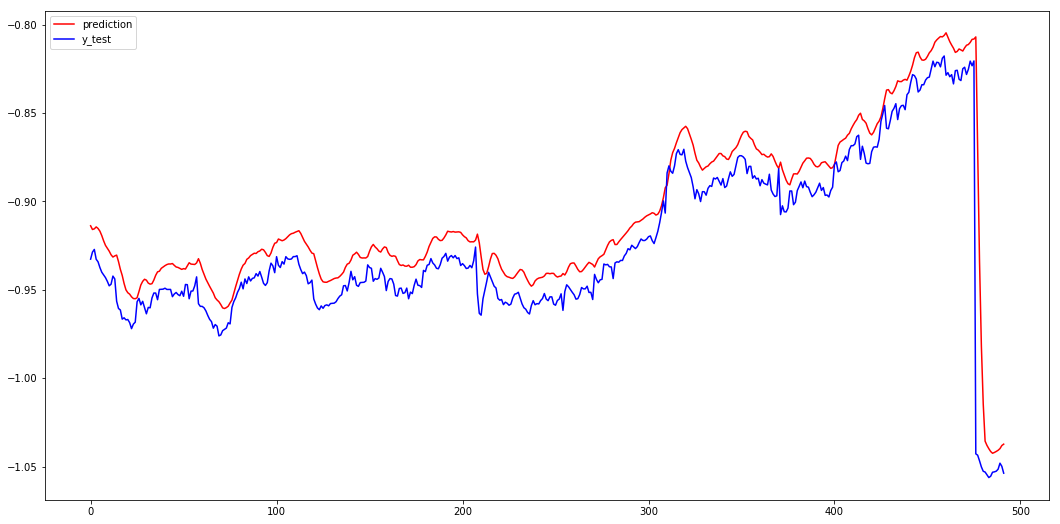

In [22]:
import matplotlib.pyplot as plt2
plt2.figure(figsize = (18,9))
plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

## Sentiment Analysis

In [23]:
consumer_key= 'E0pFYVai9VaOhqLiRBEC6gpGF'
consumer_secret= 'XAMh4l9XL5nwFK3MN5tAjtXA2YgDN1tw5f7L2n6dz5ib8VYlbm'

access_token='3261604734-86c7DOJP98GwNeFWzvgPQKFUTyHn1ZFwlloJP3v'
access_token_secret='eXEmlEAdxaFjueVP03jsAWeOeNMkI7ToiDQkyvLDa6eX7'

In [24]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [ ]:
public_tweets = api.search('Infosys', count = 1000)

In [ ]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

In [ ]:
def get_tweet_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [ ]:
positive = 0
negative = 0
neutral = 0
print(len(public_tweets))
for tweet in public_tweets:
#     print(tweet.text)
    print(clean_tweet(tweet.text))
    sentiment = get_tweet_sentiment(tweet.text) 
    print(sentiment)
    if sentiment == 'positive':
        positive += 1
    elif sentiment == 'negative':
        negative += 1
    elif sentiment == 'neutral':
        neutral += 1
    print("")

In [ ]:
print('Positive:', positive)
print('Negative:', negative)
print('Neutral:', neutral)